In [1]:
from pyspecter.SPECTER import SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation
from pyshaper.Shaper import Shaper

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, random_triangles, kT_N
from rikabplotlib.plot_utils import newplot, plot_event


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

2024-04-12 15:23:24.666450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Using CPU!


In [2]:
# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "Random Points"
n_samples =  250 # CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 7 # Note that runtime is pad^2, memory is pad^4



# Make a dataset of random 2D points of shape (n_samples, pad, 3)
dataset = np.random.rand(n_samples, pad, 3)

# normalize so that the sum of the pTs is 1
dataset[:,:,0] = dataset[:,:,0] / np.sum(dataset[:,:,0], axis=1)[:,None]
dataset[:,:,1:] = dataset[:,:,1:] - 0.5
weights = np.ones(n_samples) / n_samples


epsilon = 0.001
prong = np.array([[1-epsilon, 0, 0], [epsilon, 0, epsilon]] )

# Make n_samples copies of the prong
prongs = np.tile(prong, (n_samples, 1, 1))



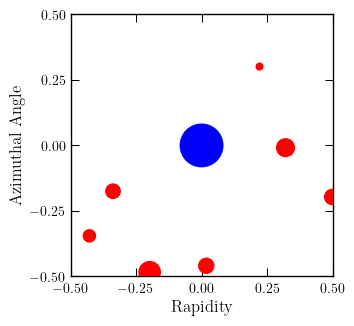

In [3]:
# Plots
fig, ax = newplot("column")

# Plot the first event
plot_event(ax, dataset[0],R, color = "red")
plot_event(ax, prong,R, color = "blue")


In [4]:
specter = SPECTER(compile = True)

def run_analysis(dataset1, dataset2):

    # Set up and compile SPECTER

    start = time.time()
    specter_emds = specter.spectralEMD(dataset1, dataset2)
    end = time.time()
    print("SPECTER took {} seconds".format(end - start))

    # Set up and compile SHAPER
    shaper = Shaper({}, device)
    shaper.to(device)

    start = time.time()
    shaper_emds = shaper.pairwise_emds_isometry(dataset1, dataset2, R = R, beta = 2, lr = 0.01, epsilon = 0.001)
    # shaper_emds_no_isometry = shaper.pairwise_emds2(dataset, prongs, R = R, beta = 2, epsilon = 0.01)
    end = time.time()
    print("SHAPER took {} seconds".format(end - start))

    return specter_emds, shaper_emds


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  2.7647833824157715  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  28.570284843444824  seconds.
Compilation complete! Time taken:  28.570300340652466  seconds.


In [5]:
# import matplotlib

# # plt.scatter(specter_emds, shaper_emds)
# # plt.scatter(specter_emds, shaper_emds_no_isometry)

# # log 2d histogram
# newplot("full")

# log = False
# xbins = np.logspace(-4, 0, 25)
# ybins = np.logspace(-4, 0, 25)
# if log:
#     plt.hist2d(specter_emds, shaper_emds, norm = matplotlib.colors.LogNorm(), bins = [xbins, ybins], density=False)
# else:
#     plt.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], density=False)
# # diagonal line
# x = np.linspace(0, 1, 1000)
# plt.plot(x, x, color = "black")

# plt.xlabel("SPECTER EMD")
# plt.ylabel(r"2 SHAPER EMD$^{\beta = 2}$ / (Isometries)")
# plt.xscale("log")
# plt.yscale("log")
# cbabr = plt.colorbar()
# cbabr.set_label("Events")



SPECTER took 1.1274986267089844 seconds
Epoch 0 Mean Loss = 0.33114711073040964 Elapsed time = 0.064s Percentage done = 0.000 
Epoch 1 Mean Loss = 0.32344496572017667 Elapsed time = 0.084s Percentage done = 0.000 
Epoch 2 Mean Loss = 0.31651090627908707 Elapsed time = 0.101s Percentage done = 0.000 
Epoch 3 Mean Loss = 0.31031117284297943 Elapsed time = 0.120s Percentage done = 0.000 
Epoch 4 Mean Loss = 0.3047810858488083 Elapsed time = 0.142s Percentage done = 0.000 
Epoch 5 Mean Loss = 0.2998603056371212 Elapsed time = 0.185s Percentage done = 0.000 
Epoch 6 Mean Loss = 0.2955005335211754 Elapsed time = 0.233s Percentage done = 0.000 
Epoch 7 Mean Loss = 0.291655059248209 Elapsed time = 0.275s Percentage done = 0.000 
Epoch 8 Mean Loss = 0.2882760538756847 Elapsed time = 0.321s Percentage done = 0.000 
Epoch 9 Mean Loss = 0.2853159854710102 Elapsed time = 0.366s Percentage done = 0.000 
Epoch 10 Mean Loss = 0.28273071575164793 Elapsed time = 0.410s Percentage done = 0.000 
Epoch 11 

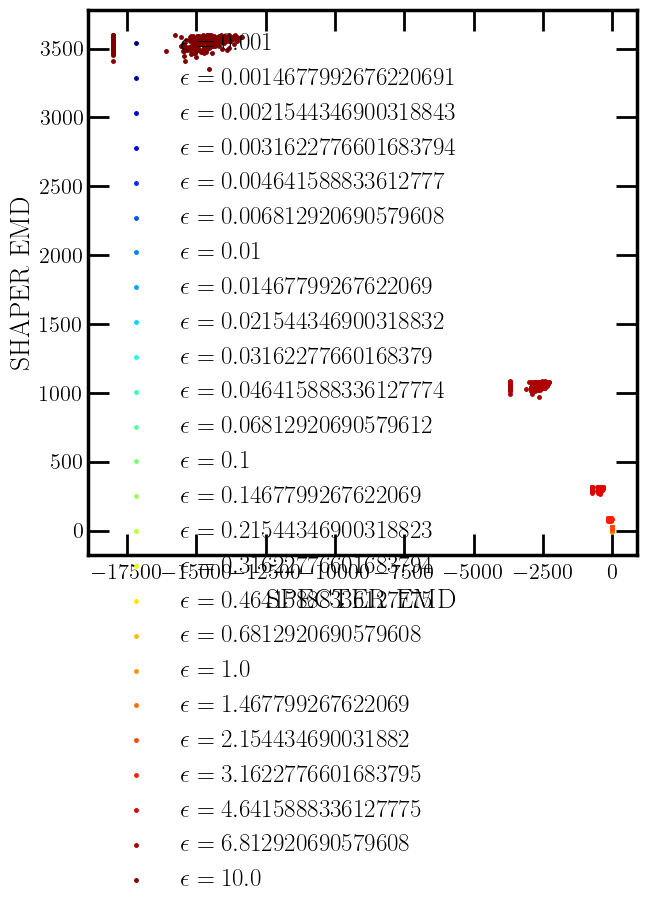

In [6]:
def compute_exactly(dataset, epsilon):

    semds = []
    for event in dataset:
        spectral_events = compute_spectral_representation(event)

        term1 = np.sum(spectral_events[:,0] * (np.power(spectral_events[:,1], 2)))
        term2 = 2 * (epsilon - epsilon**2) * epsilon**2
        term3 = -4 * epsilon * spectral_events[-1,1] * (epsilon - epsilon**2)

        semds.append(term1 + term2 + term3)

    return np.array(semds)

exact_semds = compute_exactly(dataset, epsilon)


def epsilon_plots(epsilons):

    fig, ax = newplot("full")

    colors = plt.cm.jet(np.linspace(0, 1, len(epsilons)))

    specter_emds_list = []
    shaper_emds_list = []

    for (i, epsilon) in enumerate(epsilons):

        prong = np.array([[1-epsilon, 0, 0], [epsilon, 0, epsilon]] )
        prongs = np.tile(prong, (n_samples, 1, 1))

        exact_semds = compute_exactly(dataset, epsilon)
        specter_emds, shaper_emds = run_analysis(dataset, prongs)
        plt.scatter(specter_emds, shaper_emds, label = r"$\epsilon = {}$".format(epsilon), color = colors[i])
        # plt.scatter(specter_emds, exact_semds, label = r"$\epsilon = {}$ (Exact)".format(epsilon), marker = "x", color = colors[i])

        specter_emds_list.append(specter_emds)
        shaper_emds_list.append(shaper_emds)

    plt.xlabel("SPECTER EMD")
    plt.ylabel("SHAPER EMD")
    plt.legend()
    plt.show()

    return specter_emds_list, shaper_emds_list

epsilons = np.logspace(-3, 1, 25)
specter_emds_list, shaper_emds_list =  epsilon_plots(epsilons)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


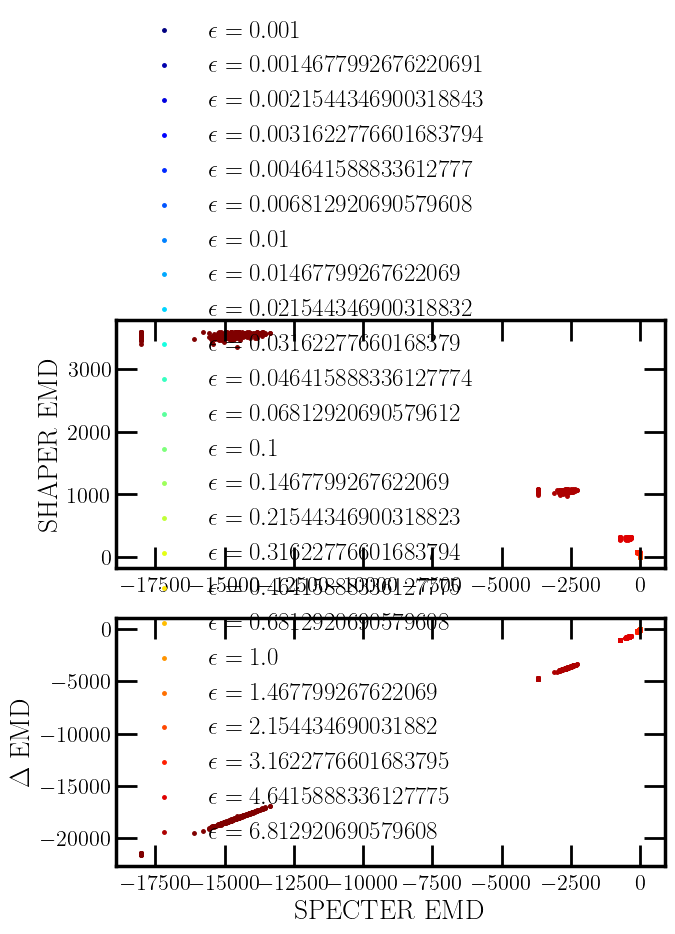

In [7]:
# Scatter plot with shaper vs specter and difference plot underneath

fig, axes = newplot("full", subplot_array=(2,1))

colors = plt.cm.jet(np.linspace(0, 1, len(specter_emds_list)))

for (i, epsilon) in enumerate(epsilons):


    axes[0].scatter(specter_emds_list[i], shaper_emds_list[i], label = r"$\epsilon = {}$".format(epsilon), color = colors[i])
    
        # plt.scatter(specter_emds, exact_semds, label = r"$\epsilon = {}$ (Exact)".format(epsilon), marker = "x", color = colors[i])
    
    plt.xlabel("SPECTER EMD")
    axes[0].set_ylabel("SHAPER EMD")
    plt.legend()

    # Difference plot
    diff = specter_emds_list[i] - shaper_emds_list[i]
    axes[1].scatter(specter_emds_list[i], diff, label = r"$\epsilon = {}$".format(epsilon), color = colors[i])
    axes[1].set_ylabel(r"$\Delta$ EMD")
    


Min EiEJ:  [1.85625684e-02 7.24622328e-03 3.12266243e-03 1.10887755e-02
 4.84118657e-03 6.57263538e-03 6.60908548e-03 7.64105935e-03
 3.38159176e-03 3.98279990e-05 3.17216897e-03 1.85739174e-02
 1.96954948e-04 7.54273776e-03 2.95483992e-02 4.40216577e-03
 9.24047927e-05 8.37016478e-03 1.65187789e-03 2.60420572e-02
 1.29963132e-02 7.37434544e-04 8.20356980e-03 2.87476392e-03
 7.19340169e-04 8.52803700e-03 5.97727112e-03 7.37542938e-03
 3.31930746e-03 1.30571425e-02 1.71593390e-03 3.04281875e-03
 1.98479015e-02 7.15524144e-03 1.50168696e-02 9.13826190e-03
 8.57104140e-04 1.46016164e-03 1.03406506e-02 1.87354919e-03
 3.28965043e-03 1.43154699e-03 1.91955327e-03 1.77197997e-02
 6.30240887e-03 3.74909816e-03 9.29615088e-03 1.07930265e-02
 4.54436103e-03 5.72757679e-04 2.80720089e-03 1.36337150e-02
 9.84121114e-04 1.92072440e-03 1.43524464e-02 1.12561984e-02
 1.46095443e-03 6.33668201e-03 3.00566526e-03 2.61609862e-03
 5.29467501e-03 2.28246357e-02 1.82064064e-03 1.70725193e-02
 5.64377010e-

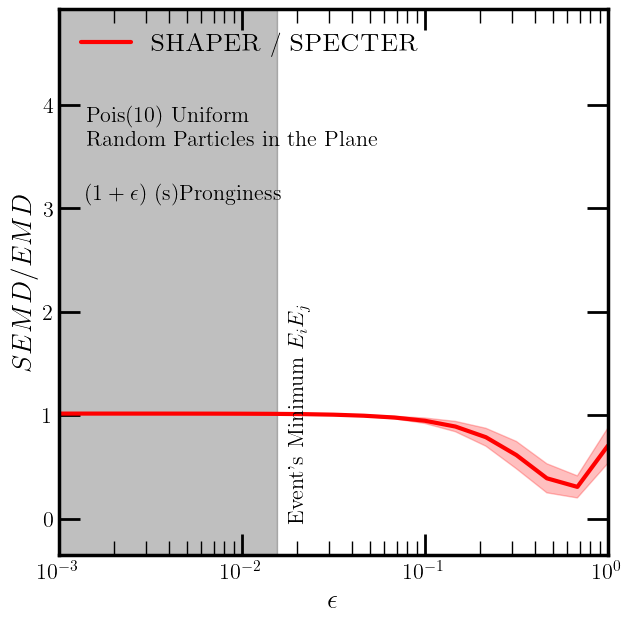

In [8]:
# plot the average difference as a function of epsilon

fig, ax = newplot("full")

diffs = []
diffs_std = []
for (i, epsilon) in enumerate(epsilons):
    diff = np.mean(specter_emds_list[i] / shaper_emds_list[i])
    diff_std = np.std(specter_emds_list[i] / shaper_emds_list[i])
    diffs.append(np.abs(diff))
    diffs_std.append(diff_std)

plt.plot(epsilons, diffs, label = r"\textsc{SHAPER} / \textsc{SPECTER}", color = "red")
plt.fill_between(epsilons, np.array(diffs) - np.array(diffs_std), np.array(diffs) + np.array(diffs_std), alpha = 0.25, color = "red")
plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$SEMD/EMD$")
plt.xlim(epsilons[0], 1)

# Text
plt.legend(loc = "upper left")
plt.text(0.05, 0.75, "$\mathrm{Pois}(10)$ Uniform\nRandom Particles in the Plane", transform = ax.transAxes)
plt.text(0.05, 0.65, r"$(1+\epsilon)$ (s)Pronginess", transform = ax.transAxes)

def calc_min_EiEJ(dataset):

    mins = []
    for event in dataset:
        spectral_events = compute_spectral_representation(event)
        
        # get the minimum EiEJ of non-zero elements
        spectral_events = spectral_events[spectral_events[:,0] > 0]
        mins.append(np.min(spectral_events[:,0]))

    return np.array(mins)

min_EiEJ = calc_min_EiEJ(dataset)
average_min = np.mean(min_EiEJ)
std_min = np.std(min_EiEJ)
print("Min EiEJ: ", min_EiEJ)

# Vertical band for the minimum EiEJ
plt.axvspan(average_min - std_min, average_min + std_min, alpha=0.25, color='black')

# Text for the minimum EiEJ
plt.text(average_min + 0.01, 1e-3, "Event's Minimum $E_iE_j$", color = "black", rotation = 90)

plt.savefig("epsilon_study.pdf", bbox_inches = "tight")    